# Normalization comparisson
In this notebook, I compare the different methods of normalization.
As a simple metric, I use the enrichment score at 99%.
This analysis is done on the efficientnetB0 pretrained output: `level3.csv`


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycytominer import aggregate, annotate, normalize, feature_select, cyto_utils
from cytominer_eval import evaluate
from cytominer_eval.transform import metric_melt
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('aggregated_efficientnet_median.csv', low_memory=False)

FileNotFoundError: [Errno 2] No such file or directory: 'aggregated_efficientnet_median.csv'

In [ ]:
p = 0.995
meta = pd.read_csv('/Users/mbornhol/git/neural-profiling/pre-trained/data-prep/02_index_preperation/repurposing_info_external_moa_map_resolved.tsv', sep='\t')
meta = meta[['broad_sample', 'moa']]
meta.rename(columns = {'broad_sample' : 'Metadata_broad_sample', 'moa' : 'Metadata_moa'}, inplace=True)

In [ ]:
def hist(df, features):
    melt = metric_melt(df.sample(200),
            features=features,
            metadata_features=meta_features)
    #bins = np.arange(-0.005, 0.005, 0.001)
    plt.style.use({'figure.facecolor':'white'})
    plt.hist(melt.similarity_metric)
def feats(df):
    features_ = []
    for col in df.columns.tolist():
        if col.startswith('efficientnet_'):
            features_.append(col)
    return features_

In [ ]:
features = feats(df)
meta_features = []
for col in df.columns.tolist():
    if col.startswith('Metadata_'):
        meta_features.append(col)

In [ ]:
# plot the similarity of the wells. Expected output from a pretrained net.
hist(df,features)

In [ ]:
# def pca_plot(df):
#     pca = PCA(n_components=3)
#     pca_result = pca.fit_transform(df[features].values)
#     df['pca-one'] = pca_result[:,0]
#     df['pca-two'] = pca_result[:,1]
#     df['pca-three'] = pca_result[:,2]
#     print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
#     plt.style.use({'figure.facecolor':'white'})
#     plt.scatter(df['pca-one'], df['pca-two'], s = 3, alpha= 0.4)
#     plt.show()
# pca_plot(df)

## Without normalization

In [ ]:
con = aggregate(
    df,
    strata=["Metadata_broad_sample"],
    features=features
)
con = pd.merge(con, meta, how='left', on=['Metadata_broad_sample'])
res = evaluate(
        profiles=con,
        features=features,
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="enrichment",
        similarity_metric="pearson",
        enrichment_percentile=p
    )
res

## robustize

There doesn't seem to be a large difference between DMSO and all normalization.

In [ ]:
rob_DMSO = normalize(
    profiles=df,
    features=features,
    samples="Metadata_broad_sample == 'DMSO'",
    method='robustize',
    output_file='none'
)
con = aggregate(
    rob_DMSO,
    strata=["Metadata_broad_sample"],
    features=features
)
con = pd.merge(con, meta, how='left', on=['Metadata_broad_sample'])
res_rob_DMSO = evaluate(
        profiles=con,
        features=features,
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="enrichment",
        similarity_metric="pearson",
        enrichment_percentile=p
    )
res_rob_DMSO

In [ ]:
rob_all = normalize(
    profiles=df,
    features=features,
    samples="all",
    method='robustize',
    output_file='none'
)
con = aggregate(
    rob_all,
    strata=["Metadata_broad_sample"],
    features=features
)
con = pd.merge(con, meta, how='left', on=['Metadata_broad_sample'])
res_rob_all = evaluate(
        profiles=con,
        features=features,
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="enrichment",
        similarity_metric="pearson",
        enrichment_percentile=p
    )
res_rob_all

## standardize

In [ ]:
stand_dmso = normalize(
    profiles=df,
    features=features,
    samples="Metadata_broad_sample == 'DMSO'",
    method='standardize',
    output_file='none'
)
con = aggregate(
    stand_dmso,
    strata=["Metadata_broad_sample"],
    features=features
)
con = pd.merge(con, meta, how='left', on=['Metadata_broad_sample'])
res_stand_dmso = evaluate(
        profiles=con,
        features=features,
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="enrichment",
        similarity_metric="pearson",
        enrichment_percentile=p
    )
res_stand_dmso

## Mad robustize

In [3]:
mad_dmso = normalize(
    profiles=df,
    features=features,
    samples="Metadata_broad_sample == 'DMSO'",
    method='mad_robustize',
    output_file='none'
)
con = aggregate(
    mad_dmso,
    strata=["Metadata_broad_sample"],
    features=features
)
con = pd.merge(con, meta, how='left', on=['Metadata_broad_sample'])
res_mad_dmso = evaluate(
        profiles=con,
        features=features,
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="enrichment",
        similarity_metric="pearson",
        enrichment_percentile=p
    )
res_mad_dmso

NameError: name 'df' is not defined

## spherize

In [4]:
sphere = normalize(
    profiles=df,
    features=features,
    samples="Metadata_broad_sample == 'DMSO'",
    method='spherize',
    output_file='none'
)
con = aggregate(
    sphere,
    strata=["Metadata_broad_sample"],
    features=features
)
con = pd.merge(con, meta, how='left', on=['Metadata_broad_sample'])
res_sphere = evaluate(
        profiles=con,
        features=features,
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="enrichment",
        similarity_metric="pearson",
        enrichment_percentile=p
    )
res_sphere

NameError: name 'df' is not defined

## mad_rob and then spherize

In [5]:
normed = normalize(
    profiles=df,
    features=features,
    samples="Metadata_broad_sample == 'DMSO'",
    method='mad_robustize',
    output_file='none'
)

sphere = normalize(
    profiles=normed,
    features=features,
    samples="Metadata_broad_sample == 'DMSO'",
    method='spherize',
    output_file='none'
)
con = aggregate(
    sphere,
    strata=["Metadata_broad_sample"],
    features=features
)
con = pd.merge(con, meta, how='left', on=['Metadata_broad_sample'])
res_sphere = evaluate(
        profiles=con,
        features=features,
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="enrichment",
        similarity_metric="pearson",
        enrichment_percentile=p
    )
res_sphere

NameError: name 'df' is not defined

## Plot PCA

Explained variation per principal component: [0.50562739 0.10818844 0.06836398]
Explained variation per principal component: [0.43458172 0.13342128 0.0787094 ]
Explained variation per principal component: [0.51577579 0.08585414 0.06115663]
Explained variation per principal component: [0.50952242 0.10840054 0.06856008]


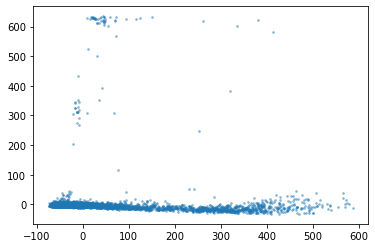

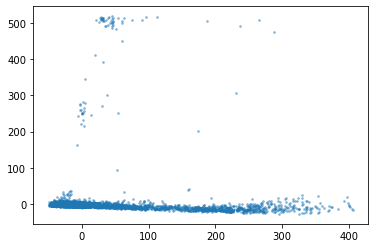

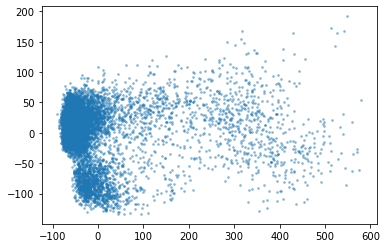

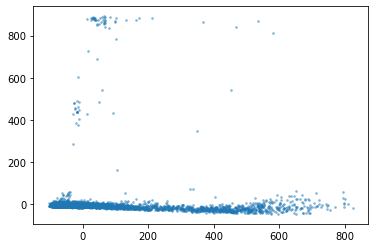

In [28]:
pca_plot(rob_DMSO)
pca_plot(rob_all)
pca_plot(stand_dmso)
pca_plot(mad_dmso)

Explained variation per principal component: [0.18571787 0.12333439 0.05559476]
Explained variation per principal component: [0.18571787 0.12333439 0.05559476]


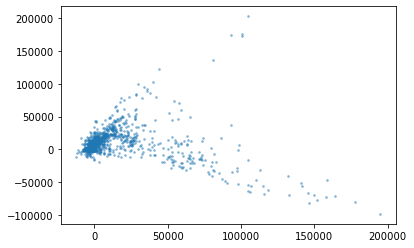

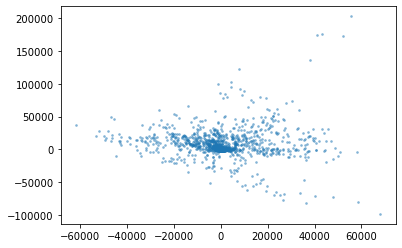

In [29]:
pca_plot(sphere)
pca = PCA(n_components=3)
pca_result = pca.fit_transform(sphere[features].values)
sphere['pca-one'] = pca_result[:,0]
sphere['pca-two'] = pca_result[:,1]
sphere['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
plt.style.use({'figure.facecolor':'white'})
plt.scatter(sphere['pca-three'], sphere['pca-two'], s = 3, alpha= 0.4)
plt.show()

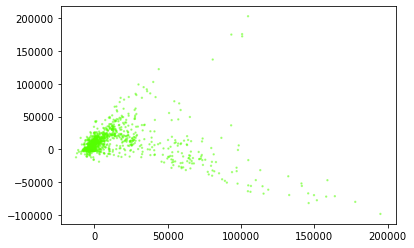

In [30]:
def is_dmso(sample):
    if sample == 'DMSO':
        return 0
    else:
        return 1
sphere['color'] = sphere.Metadata_broad_sample.apply(is_dmso)
plt.style.use({'figure.facecolor':'white'})
plt.scatter(sphere['pca-one'], sphere['pca-two'], c = sphere['color'], marker= 'o', s = 2, alpha= 0.4, cmap = 'prism')
plt.show()

## Feature selection

In [31]:
feature_select_ops = [
    "variance_threshold",
]
select_var = feature_select(
    profiles=sphere,
    features=features,
    operation=feature_select_ops,
    freq_cut=0.01,
    unique_cut=0.1,
)
print(select_var.shape)

(8733, 6421)


Variance threshold with the standard cutoffs has no effect

In [32]:
feature_select_ops = [
    "drop_outliers",
]
select_other = feature_select(
    profiles=sphere,
    features=features,
    operation=feature_select_ops,
    outlier_cutoff=10000,
)

In [34]:
features_ = feats(select_other)
con = aggregate(
    select_other,
    strata=["Metadata_broad_sample"],
    features=features_
)
con = pd.merge(con, meta, how='left', on=['Metadata_broad_sample'])
res_select_other = evaluate(
        profiles=con,
        features=features_,
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="enrichment",
        similarity_metric="pearson",
        enrichment_percentile=p
    )
res_select_other

,enrichment_percentile,threshold,ods_ratio,p-value
0,0.99,0.287813,10.003044,0.0


In [21]:
# droping a 1000 features that have very high values helps a little bit
select_other.shape

(6098, 5050)